<a href="https://colab.research.google.com/github/nova-zl504/gansdojo-example/blob/master/gandojo_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of using dansdojo to train the gan on MNIST

Use pip to install the gansdojo.


```
$> pip install gansdojo
```

Please Note: gansdojo only works under eager mode of Tensorflow.

In [0]:
try:
  import gansdojo
except:
  !pip install gansdojo
  import gansdojo

import tensorflow as tf
tf.enable_eager_execution()
import numpy as np

from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, ReLU, Reshape, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

# Prepare the dataset

*I don't know why the background of the display image are white. I though it should be black.*

Instructions for updating:
Colocations handled automatically by placer.


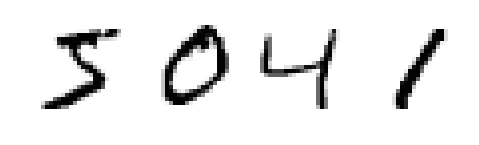

In [2]:
def open_dataset(batch_size=64):
    train, _ = tf.keras.datasets.mnist.load_data()
    X, y = train
    X = (X.astype(np.float32)/255 * 2.0) - 1.0
    X = X.reshape((X.shape[0], 28, 28, 1))
    
    return tf.data.Dataset.from_tensor_slices(X).batch(batch_size)
  
def test_dataset():
  dataset = open_dataset(4)
  data = next(iter(dataset))
  combined = K.concatenate(data, axis=1)
  combined = K.squeeze(combined, axis=-1)
  combined = (combined + 1.0) / 2.0 * 255.0
  plt.imshow(combined)
  plt.axis('off')
  plt.show()
  
tf.reset_default_graph()
test_dataset()
  

# Loss functions

We use [Least Squares Generative Adversarial Networks](https://arxiv.org/abs/1611.04076)

In [0]:
def compute_generator_loss(logits_generated, logits_real, generated, batch, generator):
  return tf.reduce_mean((logits_generated - 1.0)**2) / 2.0
  
def compute_discriminator_loss(logits_generated, logits_real, generated, batch, generator):
    D_loss_real = tf.reduce_mean((logits_real - 1)**2)
    D_loss_fake = tf.reduce_mean(logits_generated**2)
    D_loss = (D_loss_real + D_loss_fake) / 2.0
    return D_loss



# Prepare the generator and discriminator

We architect the networks with DCGAN

In [0]:

def build_generator() -> Model:
    model = Sequential()

    model.add(Dense(7 * 7 * 256, input_dim=256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Reshape([7, 7, 256]))

    model.add(Conv2DTranspose(128, 5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(64, 5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2D(1, 5, padding='same', activation='tanh'))

    return model

def build_discriminator() -> Model:
    model = Sequential()

    model.add(Conv2D(32, 5, strides=2, padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, 5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, 5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Flatten())
    model.add(Dense(1))

    return model


# Wire everything together and train the GANs!

In [0]:
from gansdojo import Dojo, ObservableDojo, Config
from gansdojo.modules import TensorBoardLogger, SampleRunner, CheckpointSaver, ConsoleUpdator

!rm -rf logs

config = Config(
    training_ratio=1,
    input_dim=256,
    dataset=open_dataset,
    batches_per_epoch=200,
    generator=build_generator,
    discriminator=build_discriminator,
    optimizer_generator=tf.train.AdamOptimizer(1e-4),
    optimizer_discriminator=tf.train.AdamOptimizer(1e-4),
    generator_loss_fn=compute_generator_loss,
    discriminator_loss_fn=compute_discriminator_loss)

observable = ObservableDojo(config)
plugins = [ConsoleUpdator(), CheckpointSaver('checkpoints'), TensorBoardLogger('logs'), SampleRunner()]
for plugin in plugins:
    plugin.setup(observable)
    
observable.train(epochs=100)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

4960 E:25 I:160 7.80 b/s G:1.9298e-01 D:1.7695e-01